In [14]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

import re
import os
import numpy as np
import pandas as pd 
import seaborn as sns
from shutil import copyfile
from tqdm import tqdm

import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, ReLU, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras import regularizers

import tensorflow as tf
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from skimage import transform

# Exploring the Data

In [15]:
# path variables
data_dir = "color/"

# get list of all classes
classes = os.listdir(data_dir)
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spid

In [16]:
# number of images in each class

image_counts = {}
for c in classes:
    try:
        path = data_dir + c
        count = len(os.listdir(path))
        image_counts[c] = count
    except:
        pass
    
df = pd.DataFrame.from_dict(image_counts, orient='index')
df

0
Apple___Apple_scab                                   630
Apple___Black_rot                                    621
Apple___Cedar_apple_rust                             275
Apple___healthy                                     1645
Blueberry___healthy                                 1502
Cherry_(including_sour)___healthy                    854
Cherry_(including_sour)___Powdery_mildew            1052
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   513
Corn_(maize)___Common_rust_                         1192
Corn_(maize)___healthy                              1162
Corn_(maize)___Northern_Leaf_Blight                  985
Grape___Black_rot                                   1180
Grape___Esca_(Black_Measles)                        1383
Grape___healthy                                      423
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)          1076
Orange___Haunglongbing_(Citrus_greening)            5507
Peach___Bacterial_spot                              2297
Peach___healthy                                      360
Pepper,_bell___Bacterial_spot                        997
Pepper,_bell___healthy                              1478
Potato___Early_blight                               1000
Potato___healthy                                     152
Potato___Late_blight                                1000
Raspberry___healthy                                  371
Soybean___healthy                                   5090
Squash___Powdery_mildew                             1835
Strawberry___healthy                                 456
Strawberry___Leaf_scorch                            1109
Tomato___Bacterial_spot                             2127
Tomato___Early_blight                               1000
Tomato___healthy                                    1591
Tomato___Late_blight                                1909
Tomato___Leaf_Mold                                   952
Tomato___Septoria_leaf_spot                         1771
Tomato___Spider_mites Two-spotted_spider_mite       1676
Tomato___Target_Spot                                1404
Tomato___Tomato_mosaic_virus                         373
Tomato___Tomato_Yellow_Leaf_Curl_Virus              5357

In [17]:
# get path and label for each image

"""
enumerate function allows up to loop over something and have an automatic counter.

we make a dataframe here which contains the file, label and its class name.

working of the code- we go to each subfolder available in the main folder and since the name of each subfolder
is the class_name, we append the files in each subfolder while naming it in the format of class_name/file_name
to a list df along with label(with help of enumerate) and class name
"""

df = []
for label, class_name in enumerate(classes):
    path = data_dir + class_name
    for file in os.listdir(path):
        df.append(['{}/{}'.format(class_name, file), label, class_name])
        
df = pd.DataFrame(df, columns=['file', 'label', 'class_name'])

# showing few datapoints
df.head()

file  label  \
0  Apple___Apple_scab/00075aa8-d81a-4184-8541-b69...      0   
1  Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78...      0   
2  Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620...      0   
3  Apple___Apple_scab/0208f4eb-45a4-4399-904e-989...      0   
4  Apple___Apple_scab/023123cb-7b69-4c9f-a521-766...      0   

           class_name  
0  Apple___Apple_scab  
1  Apple___Apple_scab  
2  Apple___Apple_scab  
3  Apple___Apple_scab  
4  Apple___Apple_scab

In [18]:
# function used in plotting
import re

"""
read_img function is used to take a image and convert it to array and format_name is used to replace _ with space
"""

def read_img(filepath, size):
    """
    Read and resize image.
    # Arguments
        filepath: path of image
        size: resize the original image.
    # Returns
        Image as numpy array
    """
    
    img = image.load_img(data_dir + filepath, target_size=size)
    img = image.img_to_array(img)
    return img

def format_name(s):
    return re.sub('_+', ' ', s)

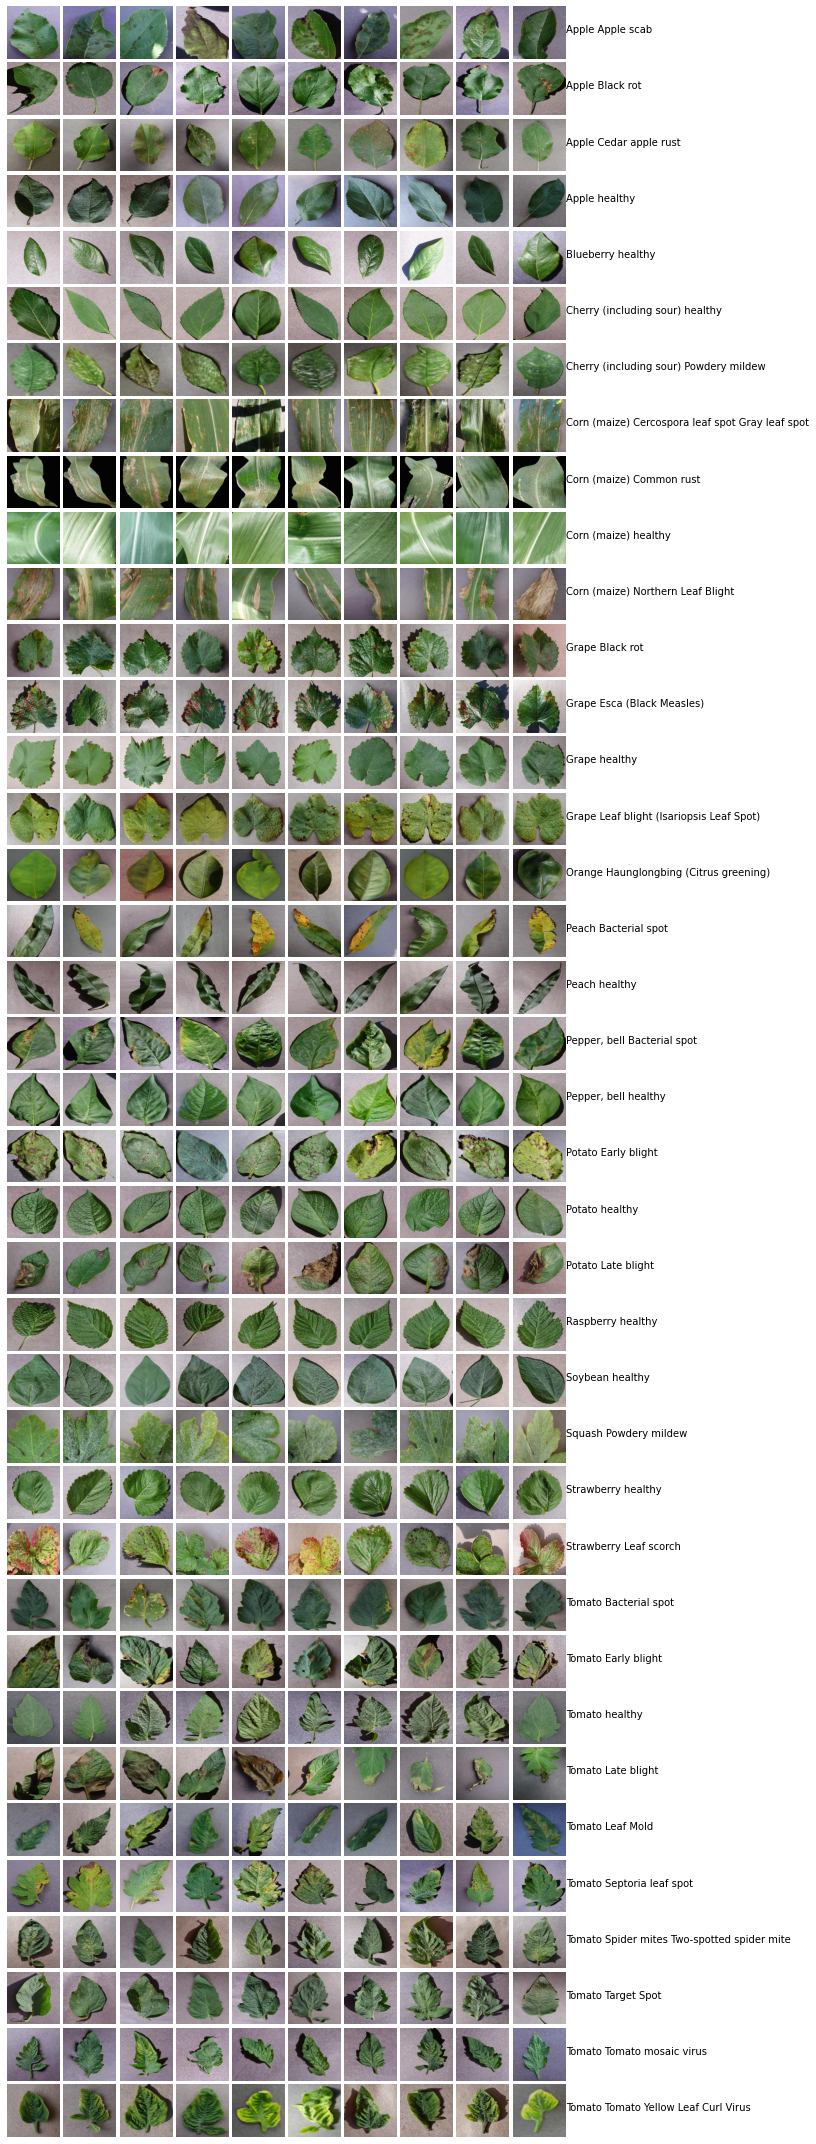

In [19]:
from matplotlib import pyplot as plt

""" This code is plotting 10 images from each class """

# Plot some images
num_classes = len(classes)
fig = plt.figure(1, figsize=(10, 40))
grid = ImageGrid(fig, 111, nrows_ncols=(num_classes, 10), axes_pad=0.05)

i = 0
for label, class_name in enumerate(classes):
    for filepath in df['file'][df['class_name'] == class_name].values[:10]:
        ax = grid[i]
        img = read_img(filepath, (256, 256))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % 10 == 10 - 1:
            name = format_name(filepath.split('/')[0])
            ax.text(260, 112, name, verticalalignment='center')
        i += 1
plt.show()
# plt.savefig("fig1.png")

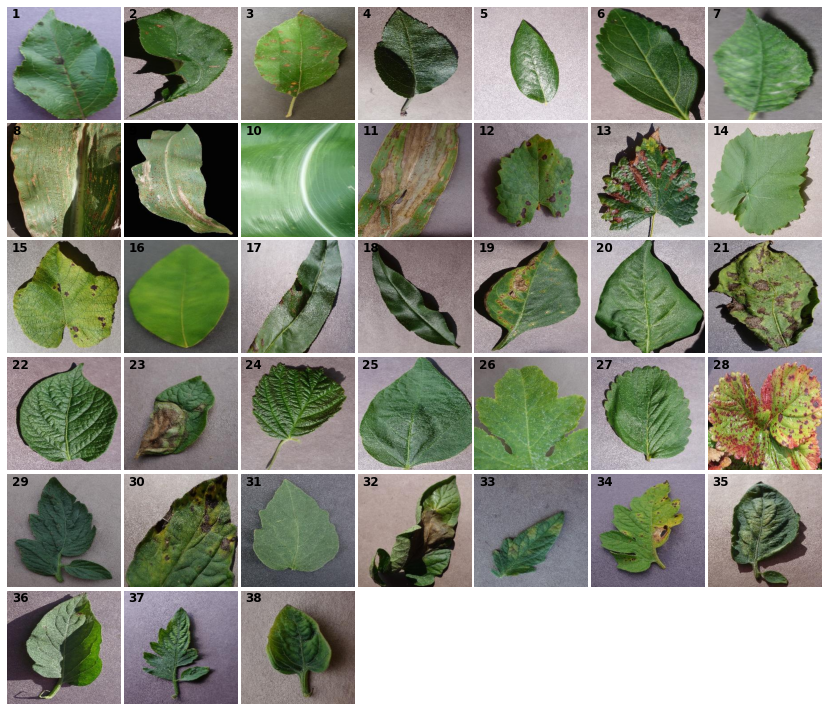

In [20]:
""" showing and labelling one image from each class """

fig = plt.figure(1, figsize=(15, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(6,7), axes_pad=0.05)

for i in range(42):
    ax = grid[i]
    ax.axis('off')
    if i < len(classes):
        class_name = classes[i]
        for filepath in df[df['class_name'] == class_name]['file'].values[:1]:
            img = read_img(filepath, (256, 256))
            ax.imshow(img / 255.)
            ax.annotate(i+1, xy=(10, 25), color="black", fontsize=12, fontweight='bold')
plt.tight_layout()
# plt.savefig("fig2.png")

# Train-Test Split

In [21]:
# set input directory

"""
in data dir, we mention the path which contains the data folder
"""

data_dir = "color/"

# get classes
""" this will get name of all the subfolders present in main foder """

classes = os.listdir(data_dir)
num_classes = len(classes)
print("Number of classes: ", num_classes)

# create train test directories

""" with help of mkdir, we will create two folder named as train and test in main folder """

os.mkdir(data_dir + 'train')
os.mkdir(data_dir + 'test')

# create new class directories for train and test images

""" 
within train and test folder, make c subfolder where c is number of subfolder present in the main folder with
the same name as subfoler's name.
"""

for c in classes:
    os.mkdir(data_dir+'train/' + c)
    os.mkdir(data_dir+'test/' + c)
    
# get path and label for each image

"""
we make a dataframe here which contains the file, label and its class name.
we go to each subfolder available in the main folder and since the name of each subfolder is the class name,
we append the files in each subfolder while naming it in the format of class_name/file_name to df along with label(with help
of enumerate) and class name.
"""

df = []
for label, class_name in enumerate(classes):
    path = data_dir + class_name
    for file in os.listdir(path):
        df.append(['{}/{}'.format(class_name, file), label, class_name])
        
df = pd.DataFrame(df, columns=['file', 'label', 'class_name'])

# gives total no. of classes which si same as total no. of subfolder with the main folder.
num_images = len(df)

print("Number of images:", num_images)


Number of classes:  38
Number of images: 54305


In [22]:
# showing some datapoints
df.head()

file  label  \
0  Apple___Apple_scab/00075aa8-d81a-4184-8541-b69...      0   
1  Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78...      0   
2  Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620...      0   
3  Apple___Apple_scab/0208f4eb-45a4-4399-904e-989...      0   
4  Apple___Apple_scab/023123cb-7b69-4c9f-a521-766...      0   

           class_name  
0  Apple___Apple_scab  
1  Apple___Apple_scab  
2  Apple___Apple_scab  
3  Apple___Apple_scab  
4  Apple___Apple_scab

In [23]:
# sample train/test observations

"""
Using the numpy bionomial number generator, generate 54305(equal to num of images)
number with n = 1(# trails), p=0.8(train_size).
stat a loop over filename in df, if the number generated is 1, then append that image(filename) to train else it
will go to the test.
"""

tr_size = 0.8
np.random.seed(50)
num = np.random.binomial(1, tr_size, num_images)

# import images
i = 0
for file in tqdm(df['file'].values):
    from_path = data_dir + file
    if num[i] == 1:
        to_path = data_dir + 'train/' + file
    else:
        to_path = data_dir + "test/" + file
    copyfile(from_path, to_path)
    i += 1

100%|███████████████████████████████████████████████████████████████████████████| 54305/54305 [01:02<00:00, 870.81it/s]


In [24]:
# mentioning the train and test dir
TRAIN_DIR = "color/train/"
TEST_DIR = "color/test/"

In [25]:
# get path and label for each image in test and train dir and calculating no. of samples in train and test

"""
We make a dataframe here which contains the file, label, class name & train_ind.
we go to each subfolder available in the train & test folder and since the name of each subfolder
is the class name, we append the files in each subfolder while naming it in the format of class_name/file_name
to df along with label(with help of enumerate), class name and train_ind.
if the train_ind=1, then it is showing that the file is in train folder while 0 shows the file lies within test folder
"""

df = []
for label, class_name in enumerate(classes):
    
    # Train
    path = TRAIN_DIR + class_name
    for file in os.listdir(path):
        df.append(['{}/{}'.format(class_name, file), label, class_name, 1])
        
    # Test
    path = TEST_DIR + class_name
    for file in os.listdir(path):
        df.append(['{}/{}'.format(class_name, file), label, class_name, 0])

df = pd.DataFrame(df, columns=['file', 'label', 'class_name', 'train_ind'])

num_train_samples = df.train_ind.sum()
num_test_samples = len(df) - num_train_samples

print("Number of train images:", num_train_samples)
print("Number of test images:", num_test_samples)

Number of train images: 43616
Number of test images: 10689


In [26]:
# Showing some datapoints
df.head()

file  label  \
0  Apple___Apple_scab/00075aa8-d81a-4184-8541-b69...      0   
1  Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78...      0   
2  Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620...      0   
3  Apple___Apple_scab/0208f4eb-45a4-4399-904e-989...      0   
4  Apple___Apple_scab/023123cb-7b69-4c9f-a521-766...      0   

           class_name  train_ind  
0  Apple___Apple_scab          1  
1  Apple___Apple_scab          1  
2  Apple___Apple_scab          1  
3  Apple___Apple_scab          1  
4  Apple___Apple_scab          1

# Modeling

In [27]:
# using Inception V3 model

from keras.applications.inception_v3 import InceptionV3, preprocess_input

# specify data generator inputs (Image Augmentation)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [28]:
width, height, depth = 299, 299, 3
batch = 64

# create data generators
train_generator = train_datagen.flow_from_directory(
TRAIN_DIR,
target_size=(width, height),
batch_size=batch)

test_generator = test_datagen.flow_from_directory(
TEST_DIR,
target_size=(width, height),
batch_size=batch,
shuffle=False)

Found 43616 images belonging to 38 classes.
Found 10689 images belonging to 38 classes.


In [29]:
# transfer learning using inception v3 on imagenet dataset

# get inception model without final layer
base_model = InceptionV3(weights='imagenet', include_top=False)

#Add new fully connected layer to base model
x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

x = Dropout(rate=0.5)(x)

output = Dense(38, activation='softmax')(x)
model = Model(input=base_model.input, output=output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [31]:
# compile model

""" compile defines the loss function, the optimizer and the metrices """

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy')

In [32]:
# it will show the layer used and no of parameters after each layer
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [33]:
import itertools
class Metrices(Callback):
    
    def __init__(self, tr_data, val_data, batch_size):
        super().__init__()
        self.train_data = tr_data
        self.validation_data = val_data
        self.batch_size = batch_size
        
    def on_train_begin(self, logs={}):
        self.tr_fls=[]
        self.tr_recalls = []
        self.precisions = []
        
        self.val_fls = []
        self.val_recalls = []
        self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        batch_tr = len(self.train_data)
        total_tr = batch_tr * self.batch_size
        
        tr_pred = []
        tr_true = []
        
        for batch in range(batch_tr):
            xtr, ytr = next(self.train_data)
            
            tr_pred_batch = np.zeros((len(xtr)))
            tr_true_batch = np.zeros((len(ytr)))
            
            tr_pred_batch = np.argmax(np.asarray(self.model.predict(xtr)), axis=-1)
            tr_true_batch = np.argmax(ytr, axis=-1)
            
            tr_pred.append(tr_pred_batch)
            tr_true.append(tr_true_batch)
            
        tr_pred = np.asarray(list(itertools.chain.from_iterable(tr_pred)))
        tr_true = np.asarray(list(itertools.chain.from_iterable(tr_true)))
        
        _tr_f1 = f1_score(tr_true, tr_pred, average="weighted")
        _tr_prediction = precision_score(tr_true, tr_pred, average="weighted")
        _tr_recall = recall_score(tr_true, tr_pred, average="weighted")
        
        self.tr_fls.append(_tr_f1r)
        self.tr_recalls.append(_tr_recall)
        self.tr_precisions.append(_tr_prediction)
        
        logs["tr_fls"] = _tr_f1
        logs["tr_recalls"] = _tr_recall
        logs["tr_precision"] = _tr_prediction
        
        print("- tr_f1: {} - tr_recall: {} - tr_precision {}".format(_tr_f1, _tr_recall, _tr_prediction))
        
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = []
        val_true = []
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            
            val_pred_batch = np.zeros((len(xVal)))
            val_true_batch = np.zeros((len(xVal)))
            
            val_pred_batch = np.argmax(np.asarray(self.model.predict(xVal)), axis=-1)
            val_true_batch = np.argmax(yVal, axis=-1)
            
            val_pred.append(val_pred_batch)
            val_true.append(val_true_batch)
            
        val_pred = np.asarray(list(itertools.chain.from_iterable(val_pred)))
        val_true = np.asarray(list(itertools.chain.from_iterable(val_true)))
        
        _val_f1 = f1_score(val_true, val_pred, average="weighted")
        _val_precision = precision_score(val_true, val_pred, average="weighted")
        _val_recall = recall_score(val_true, val_pred, average="weighted")
        
        self.val_fls.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        logs["val_fls"] = _val_f1
        logs["val_recall"] = _val_recall
        logs["val_precision"] = _val_precision
        
        print("- val_f1: {} - val_recall: {} - val_precision {}".format(_val_f1, _val_recall, _val_prediction))
        
        return

metric = Metrices(train_generator, test_generator, batch_size=64)
        

In [34]:
from keras.callbacks import TensorBoard
import datetime

"""
Tensorboard is the interface used to visualise the graph and other tools to understand, debug and optimise the model.
"""

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%y%m%d-%H%M%S")
tensor = TensorBoard(log_dir=log_dir)

"""
The ModelCheckpoint callback class allows to define where to checkpoint the model weights, how tht file should named and under what 
circumstances to make ta checkpoint of the model
"""

path = "inception" + ".hdf5"

checkpoint = ModelCheckpoint(path, 
                            monitor="val_loss",
                            mode="min",
                            verbose=1,
                            save_best_only=True)

"""
ReduceLROnPlateau callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the lr is reduced
"""

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                             factor=0.2,
                             patience=4,
                             cooldown=5)

"""
CSVLogger callback store epoch results to a csv file
"""

filepath = "inception" + ".csv"

csv_log = CSVLogger(filepath)

In [ ]:
# fit transfer learning model
history = model.fit_generator(train_generator, epochs=15,
                             validation_data=test_generator,
                             validation_steps=180,
                             callbacks=[metric, checkpoint, reduce_lr, csv_log, tensor])




Epoch 1/15
  4/500 [..............................] - ETA: 6:32:01 - loss: 3.9023

In [ ]:
# plotting train and test loss and various metrices on train and test data

"""
creating a dataframe from history.history & storing val_f1, val_precision and val_recall from metric in dataframe
and then plotting the various metrices and loss.
"""

history_df = pd.DataFrame(history.history)
